# Goal
Classify 60,000 images of 10 classes through convolutional neural network (CNN).

# Findings and Conclusion
1. This project trained multi-classification CNN model on 50,000 images and tested on 10,000 images.
2. The model achieves **81.79% accuracy** on test data.
3. By analyzing the performance and training process of the first model, the second model **saves training time by 58%**, and **improves accuracy by 8.6%**.
4. There is only slight overfitting problem.
5. If more training time is given, the accuracy could be further improved, and the overfitting problem could also be reduced more.

## Table of Contents
1. Data Pre-processing
2. Modeling  
    2.1 Build Convolutional Neural Network  
    2.2 Other Considerations for Modeling  
3. Model Evaluation and Tuning  
    3.1 Evaluation  
    3.2 Improve the Model  

### Reference
   *Learning Multiple Layers of Features from Tiny Images*, Alex Krizhevsky, 2009.
   
   


# 1. Data Pre-processing

In [2]:
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils

import warnings
warnings.filterwarnings("ignore")

## Visualize the data  
The data is from Canadian Institute For Advanced Research (CIFAR). The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes. These classes are:  
- airplane										
- automobile										
- bird										
- cat										
- deer										
- dog										
- frog										
- horse										
- ship										
- truck  

These images are labeled according to their classes by number 0 ~ 9.
For each pixel in the images, the values of <font color='red'>red</font>, <font color='green'>green</font>, and <font color='blue'>blue</font> channels are stored separately. So, each image is stored as a 32x32x3 arrary. The values range from 0 to 255.  
25 randomly chosen images are visualized via the following code.

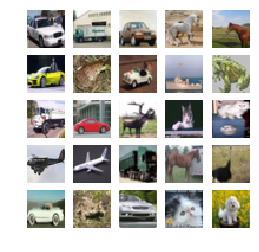

In [21]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle 

f = open('data_batch_1', 'rb')
datadict = cPickle.load(f,encoding='latin1')
f.close()
X = datadict["data"] 
Y = datadict['labels']
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
Y = np.array(Y)

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(4,4))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])

In [17]:
# Set random seed for purposes of reproducibility
seed = 100

In [4]:
from keras.datasets import cifar10

## Train/Test Split
Load CIFAR-10 images as numpy array, and split into training set and test set. 

In [5]:
# loading in the data from CIFAR
     
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 28s 0us/step


In [13]:
print('There are '+str(X_train.shape[0])+' images in the training set.')
print('There are '+str(X_test.shape[0])+' images in the test set.')

There are 50000 images in the training set.
There are 10000 images in the test set.


## Normalization
Normalize the inputs from 0-255 to between 0 and 1 by dividing by 255

In [22]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

## One-hot Encoding
One-hot encode the outputs, convert the label 0 ~ 9 into categorical data.

In [23]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
class_num = y_test.shape[1]

# 2. Modeling

## 2.1 Build Convolutional Neural Network 
The backbone of convolutional neural network contains the following layers:  
1. **Convolutional Layer**: Take the filters and slide over the entire image to capture the features of the image. The filter is a tensor, in the case here I choose the filter dimension as 3x3x3. The inputs are the values of the image within the filter window, and the output is the product of the inputs and the filter. Therefore, after the first filter applied on the image, we get an output of 28x28x1. The first convolutional layer contains 32 filters, so the output is 28x28x32.
2. **Pooling Layer**: This layer is used for dimensionality reduction while keeping the pattern of the image. The inputs are adjacent values from convolutional layer, and take their maximum, sum, or average. Hence, the output is only one value which represents the feature of a certain area. In sum, the advantages of adding pooling layer are:
    - Keep the pattern of the features
    - Ruduce dimension, and thus reduce training time, and reduce overfitting.
    - Makes the network more robust to small change of the image. Therefore, the network can work better even when the images are slightly distorted.
    - It is scale invariant representation of our image (or “equivariant”). This means it could detect the same pattern despite the location in the image.
    
In this project, I use maximum with dimension of 2x2 for pooling layers.  
3. **Fully Connected Layer**: after capturing and extracting the features from the image, a multi-layer perceptron is used for learning from the features and making final classification result as output. 

## 2.2 Modeling Details
1. **Activation Function**: activation functions are applied on each layer to capture the non-linear relationship. In this project, I use the following two kinds of activation function.
    - **ReLU** (rectified linear unit): It prevents vanishing gradient when training the neural network through backpropagation by gradient descent. The function keep only positive values. $$f(x) = x^+ = max(0, x)$$ ReLU is applied on all layers except the output layer, where we need a function to do classification.
    - **Softmax**: It's used for multi-classification, so applied on output layer. The function is: $$\sigma(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}$$  
    where K is the number of classes. Thus, *K=10* in this project.
2. **Dropout**: It's for reducing overfitting. When training the neural network, for each iteration, some of the neurons in each layer are randomly dropped. Therefore, each neuron wouldn't "learn too much" from the inputs. The dropout rate in this project is *0.2*.
3. **Padding**: After applying filter of a convolutional layer, the size of the output is smaller than the input. Padding add *0* on the border of the output to maintain the same size. It helps to keep the information on the edge of the images. Considering the image size in this project is samll, padding is applied to every convolutional layer, because we do not want to lose any information. 
4. **Batch Normalization**: It normalizes the output of each layer, to make sure there are right amount of neurons are activated.
5. **Flatten**: It's the transition between convolutional layer and fully connected layer. The output of convolutional lay is 3-D tensor, and the input of fully connected layer is 1-D vector. Therefore, the tensor needs to be *flatten* for the input to the fully connected layer.

The structure of the whole model is as the following:

**1st Convolutional Layer** (32 filters) → **2nd Convolutional Layer** (64 filters) → **Pooling Layer** → **3rd Convolutional Layer** (128 filters) → **Flatten**  
→ **1st Fully Connected Layer**  (256 neurons) → **2nd Fully Connected Layer** (128 neurons) → **Output Layer** (10 classes)  

In [30]:
# Build CNN model via keras
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
   
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(256, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
    
model.add(Dense(128, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(class_num))
model.add(Activation('softmax'))

In [31]:
# Use 25 iteration to train the model
epochs = 25
optimizer = 'adam'

**'Adam'** is for 'adaptive moment estimation.' It is a method which computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients. It has the advatages of the following two algorithms:
- **Adaptive Gradient Algorithm (AdaGrad)**: maintains a per-parameter learning rate that improves performance on problems with sparse gradients.
- **Root Mean Square Propagation (RMSProp)**: that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight The algorithm does well on online and non-stationary problems (e.g. noisy).  

Adam has such advantages because it considers both first and second moments when adapting learning rate.

Compile the model, and print the model summary.

In [32]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [33]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 64)        256       
__________

Train the model

In [34]:
numpy.random.seed(seed)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64)

W0730 16:05:38.052633 39348 deprecation.py:323] From C:\Users\Bo-Yu Chen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 479s 10ms/step - loss: 1.4277 - acc: 0.4938 - val_loss: 1.1471 - val_acc: 0.5988
Epoch 2/25
50000/50000 [==============================] - 608s 12ms/step - loss: 0.9640 - acc: 0.6579 - val_loss: 0.8497 - val_acc: 0.7006
Epoch 3/25
50000/50000 [==============================] - 580s 12ms/step - loss: 0.8292 - acc: 0.7086 - val_loss: 0.8545 - val_acc: 0.6974
Epoch 4/25
50000/50000 [==============================] - 571s 11ms/step - loss: 0.7784 - acc: 0.7276 - val_loss: 0.8182 - val_acc: 0.7140
Epoch 5/25
50000/50000 [==============================] - 579s 12ms/step - loss: 0.7479 - acc: 0.7382 - val_loss: 0.8430 - val_acc: 0.7088
Epoch 6/25
50000/50000 [==============================] - 581s 12ms/step - loss: 0.7220 - acc: 0.7470 - val_loss: 0.8518 - val_acc: 0.6976
Epoch 7/25
50000/50000 [==============================] - 579s 12ms/step - loss: 0.7057 - acc: 0.7547 - val_loss: 0.

In [35]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 75.37%


In [36]:
# save trained CNN model
model.save('image_CNN.h5')

# 3. Model Evaluation and Tunning
## 3.1 Evaluation
Evaluate the model performance by comparing in-sample and out-of-sample accuracy and loss at each epoch.

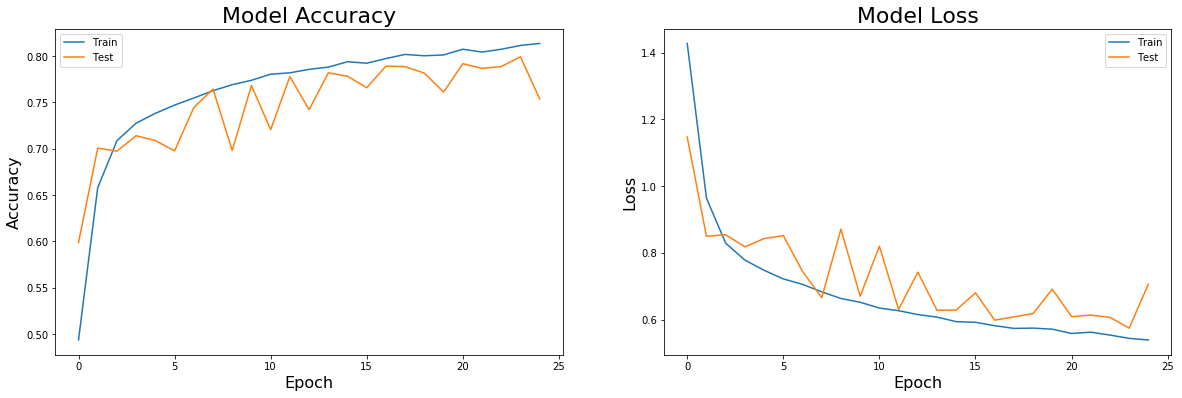

In [75]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
# summarize history for accuracy
ax1.plot(model.history.history['acc'])
ax1.plot(model.history.history['val_acc'])
ax1.set_title('Model Accuracy', fontsize=22)
ax1.set_ylabel('Accuracy', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=16)
ax1.legend(['Train', 'Test'], loc='upper left')

# summarize history for loss
ax2.plot(model.history.history['loss'])
ax2.plot(model.history.history['val_loss'])
ax2.set_title('Model Loss', fontsize=22)
ax2.set_ylabel('Loss', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=16)
ax2.legend(['Train', 'Test'], loc='upper right')


### Summay
1. As expected, the accuracy increases and loss decreases as training epoch increases.
2. Accuracy increases slower when epoch increases, but it is not completely flattern. It means the model could have better performance if trained for more time.
3. The model performance on test data is not closing to the performance of train data. It implies some overfitting problem. 
4. The CNN model achieves 81% accuracy in training data, and 75% accuracy on test data, which is not bad. So, the model just needs slight adjustment and addresses overfitting issue.


## 3.2 Improve the Model
According to my findings in the first model, I decide to do the following adjustment to improve the model performance.
1. **Add one more pooling layer** after the second convolutional layer. This will increase the pattern detection ability of the model.
2. **Change the filter size of the first pooling layer.** The performance of the first model indicates the model could capture the features well in general. So, by increasing the size of the filter, I downsampled the convolutional layer more progressively, and still kept the detected pattern. 
3. **Reduce the number of neurons in the second fully connected layer**. It is the second-last layer, and the final output is 10-class. So, too many neurons might not be helpful in this case. 
4. All of the above changes help to **prevent overfitting**, reduce number of parameters, and thus **save computational cost**.


The structure of the second model:  
**1st Convolutional Layer** (32 filters) → **2nd Convolutional Layer** (64 filters) → **1st Pooling Layer**  
→ **3rd Convolutional Layer** (128 filters) → **2nd Pooling Layer** → **Flatten**  
→ **1st Fully Connected Layer**  (256 neurons) → **2nd Fully Connected Layer** (64 neurons) → **Output Layer** (10 classes)   

The second model is built and trained as follows.  

In [95]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(3, 3)))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
   
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())

model2.add(Flatten())
model2.add(Dropout(0.2))

model2.add(Dense(256, kernel_constraint=maxnorm(3)))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
    
model2.add(Dense(64, kernel_constraint=maxnorm(3)))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())

model2.add(Dense(class_num))
model2.add(Activation('softmax'))

In [90]:
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_33 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 10, 10, 64)        0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 10, 10, 64)        256       
__________

In [91]:
epochs = 25
optimizer = 'adam'
numpy.random.seed(seed)
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 226s 5ms/step - loss: 1.5451 - acc: 0.4524 - val_loss: 1.3017 - val_acc: 0.5437
Epoch 2/25
50000/50000 [==============================] - 219s 4ms/step - loss: 1.1017 - acc: 0.6107 - val_loss: 0.9801 - val_acc: 0.6500
Epoch 3/25
50000/50000 [==============================] - 221s 4ms/step - loss: 0.9363 - acc: 0.6723 - val_loss: 0.9164 - val_acc: 0.6806
Epoch 4/25
50000/50000 [==============================] - 224s 4ms/step - loss: 0.8523 - acc: 0.6995 - val_loss: 0.7793 - val_acc: 0.7272
Epoch 5/25
50000/50000 [==============================] - 221s 4ms/step - loss: 0.7822 - acc: 0.7264 - val_loss: 0.7131 - val_acc: 0.7574
Epoch 6/25
50000/50000 [==============================] - 214s 4ms/step - loss: 0.7317 - acc: 0.7429 - val_loss: 0.7428 - val_acc: 0.7437
Epoch 7/25
50000/50000 [==============================] - 215s 4ms/step - loss: 0.7040 - acc: 0.7551 - val_loss: 0.7060 - 

In [92]:
model2.save('image_CNN_2.h5')

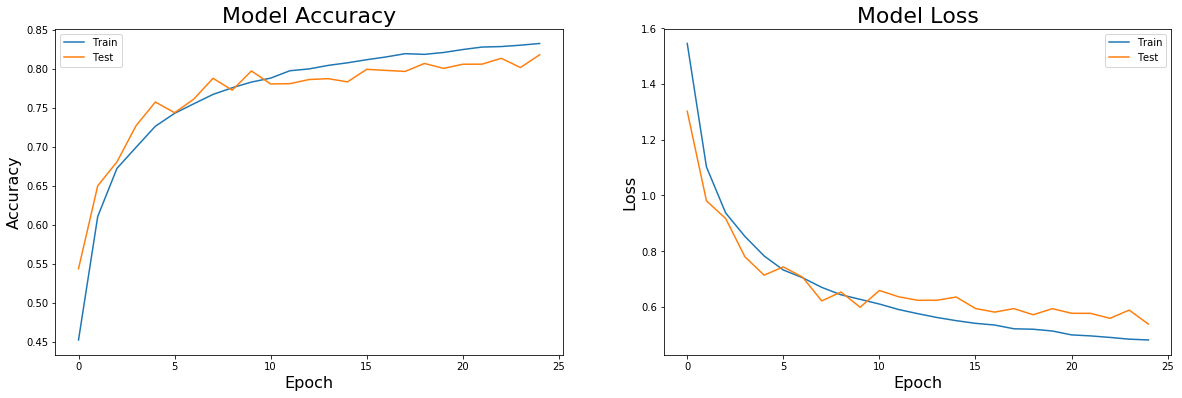

In [93]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
# summarize history for accuracy
ax1.plot(model2.history.history['acc'])
ax1.plot(model2.history.history['val_acc'])
ax1.set_title('Model Accuracy', fontsize=22)
ax1.set_ylabel('Accuracy', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=16)
ax1.legend(['Train', 'Test'], loc='upper left')

# summarize history for loss
ax2.plot(model2.history.history['loss'])
ax2.plot(model2.history.history['val_loss'])
ax2.set_title('Model Loss', fontsize=22)
ax2.set_ylabel('Loss', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=16)
ax2.legend(['Train', 'Test'], loc='upper right')

### Summary
1. The second model is more efficient, since the number of parameters is only 11% of the number in the fisrt model.
2. The second model saves 58% of training time.
3. The second model achieves 82% of accuracy, compared with the first model, it's improved by 8.6%.
4. The accuracy curve is not flatten when the epoch reaches 25. It means the performance could be further improved if more training time is given.
5. The model performance on the test data is not close to the performance on the training data. It indicates some overfitting problem, but not serious. 